### Parse the supplementary files of Ribo-seq ORFs preprints

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr

In [2]:
ncorfs = pd.read_excel('../doc/riboseqorfs/media-3.xlsx', sheet_name='Table S3')
horfs = pd.read_excel('../doc/riboseqorfs/media-5.xlsx', sheet_name='Table S5')
ncorfs.shape, horfs.shape

((183, 27), (1785, 26))

In [3]:
ncorfs.drop_duplicates('gene_id').shape, ncorfs.drop_duplicates(['transcript', 'gene_id']).shape

((181, 27), (183, 27))

In [4]:
horfs.drop_duplicates('gene_id').shape, horfs.drop_duplicates(['transcript', 'gene_id']).shape

((1563, 26), (1671, 26))

In [5]:
ncorfs = ncorfs[(ncorfs['HPP.Category']!='FP') & (ncorfs['orf_biotype']!='PT') & (ncorfs['orf_biotype']!='lncRNA-ORF')]
horfs = horfs[(horfs['orf_biotype']!='PT') & (horfs['orf_biotype']!='lncRNA-ORF')]
ncorfs.shape, horfs.shape

((87, 27), (1371, 26))

In [6]:
ncorfs.value_counts('orf_biotype')

orf_biotype
uORF      41
uoORF     19
dORF      17
intORF     7
doORF      3
Name: count, dtype: int64

In [7]:
horfs.value_counts('orf_biotype')

orf_biotype
uORF      792
intORF    241
uoORF     241
dORF       77
doORF      20
Name: count, dtype: int64

In [8]:
norfs = pd.concat([ncorfs,horfs.rename(columns={'Category':'HPP.Category'})])
norfs.drop_duplicates('Ribo-Seq_ORF', inplace=True)
norfs.shape

(1426, 34)

In [9]:
norfs['transcript'].unique().shape

(1329,)

#### Convert dataframe to genePred format

In [10]:
norfs['chrm'] = 'chr' + norfs['chrm'].astype(str)

norfs['starts'] = norfs.starts.str.split(';').apply(lambda x: [int(i)-1 for i in x])
norfs['exonCount'] = norfs.starts.apply(len)
norfs['start'] = norfs['starts'].apply(lambda x: np.min(x))
norfs['ends'] = norfs.ends.str.split(';').apply(lambda x: [int(i) for i in x])
norfs['end'] = norfs['ends'].apply(lambda x: np.max(x))
norfs['exonStarts'] = norfs.starts.apply(lambda x: ','.join([str(i) for i in x])) + ','
norfs['exonEnds'] = norfs.ends.apply(lambda x: ','.join([str(i) for i in x])) + ','
norfs.to_pickle('../doc/riboseqorfs/riboseqorfs.pkl.gz')

gp = norfs[['Ribo-Seq_ORF','chrm','strand','start','end','start','end','exonCount','exonStarts','exonEnds']]
gp.to_csv('../doc/riboseqorfs/riboseqorfs.gp', header=False, index=False, sep='\t')

#### Get no overlapping Ribo-Seq ORFs

In [11]:
! genePredToBed ../doc/riboseqorfs/riboseqorfs.gp ../doc/riboseqorfs/riboseqorfs.bed

! awk 'BEGIN{OFS="\t"} {print $1,$7,$8,$4,$5,$6}' ../ref/hg38/gencode.v47.annotation.bed \
| bedtools intersect -a ../doc/riboseqorfs/riboseqorfs.bed -b - -s -split -wao \
| awk '$NF==0' | cut -f-12 > ../doc/riboseqorfs/riboseqorfs.uniq.bed

#### Validate the genePred file for Ribo-seq_ORFs

In [13]:
! bedtools getfasta -bed ../doc/riboseqorfs/riboseqorfs.uniq.bed -fi ../ref/hg38/hg38.fa -split -name -s -tab \
| cut -f2 | cut -c-3 | sort | uniq -c

     30 atg
      6 ATg
    655 ATG


In [14]:
! bedtools getfasta -bed ../doc/riboseqorfs/riboseqorfs.uniq.bed -fi ../ref/hg38/hg38.fa -split -name -s -tab \
| cut -f2 | rev | cut -c-3 | sort | uniq -c

     12 aat
      1 AAt
    170 AAT
     29 agt
      1 Agt
    321 AGT
      5 gat
      1 gaT
    151 GAT


#### Compare ORFs found in RIBOSS orf_finder and ribotricer index

In [1]:
import pandas as pd

rt_candidate_orfs = pd.read_csv('../ref/hg38/hg38_candidate_orfs.tsv', sep='\t')
# rt_candidate_orfs = rt_candidate_orfs[rt_candidate_orfs.transcript_type.str.contains('protein_coding')].copy()

df = pd.read_pickle('../ref/hg38/gencode.v47.annotation.orf_finder.pkl.gz')
dfp = df[df['Strand']=='+'].copy()
dfm = df[df['Strand']=='-'].copy()
dfp['ORF_ID'] = dfp.tid + '_' + (dfp.Start + 1).astype(int).astype(str) + '_' + (dfp.End - 3).astype(int).astype(str) + '_' + (dfp.ORF_length - 3).astype(int).astype(str)
dfm['ORF_ID'] = dfm.tid + '_' + (dfm.Start + 4).astype(int).astype(str) + '_' + (dfm.End).astype(int).astype(str) + '_' + (dfm.ORF_length - 3).astype(int).astype(str)

df = pd.concat([dfp,dfm])
df_rt = pd.merge(df,rt_candidate_orfs, on='ORF_ID', how='outer')

rt_candidate_orfs[['tid','Start','End','ORF_length']] = rt_candidate_orfs.ORF_ID.str.split('_', expand=True)
rt_candidate_orfs[['chrom','Start','End','tid','ORF_length','strand']].to_csv('../ref/hg38/hg38_candidate_orfs.bed', header=None, index=None, sep='\t')

In [2]:
df_rt.dropna().shape, df_rt.shape, df.shape, df[df.ORF_type!='mORF'].shape, rt_candidate_orfs.shape, rt_candidate_orfs[rt_candidate_orfs.ORF_type!='annotated'].shape

((489794, 22),
 (3945234, 22),
 (1484629, 12),
 (1397050, 12),
 (2950399, 11),
 (2851239, 11))

489794 ORFs are in common between RIBOSS orf_finder and ribotricer index

In [8]:
df_rt.dropna(inplace=True)
df_rt['oid'] = df_rt.tid + '__' + df_rt.ORF_start.astype(int).astype(str) + '-' + df_rt.ORF_end.astype(int).astype(str)
df_rt[['oid','ORF_ID']].to_csv('../ref/hg38/orf_finder_ribotricer.intersection.txt', index=None, sep='\t')

#### Ribo-Seq ORFs found by RIBOSS orf_finder and ribotricer index

In [2]:
df = pd.read_pickle('../ref/hg38/gencode.v47.annotation.orf_finder.pkl.gz')
df['Start'] = df.Start.astype(int)
df['End'] = df.End.astype(int)

df.drop('ORF_range', axis=1, inplace=True)
df.to_csv('../results/park_2016_datasets/orf_finder/gencode.v47.annotation.orf_finder.txt', index=None, sep='\t')

In [3]:
! awk 'NR>1 && !/annotated/ && gsub(/_/, "\t", $1) {print $8,$1,$9,$2}' ../ref/hg38/hg38_ucsc_candidate_orfs.tsv | awk 'BEGIN{OFS="\t"}{print $1,$3,$4,$2 "|" $7,$5,$6}' \
| bedtools intersect -a - -b ../doc/riboseqorfs/riboseqorfs.uniq.bed -s -split -wo | awk '(($2==$8) || ($3==$9)) || (($2-1)==$8) || ($3==$9)' \
> ../doc/riboseqorfs/riboseqorfs.ribotricer.txt

! awk 'BEGIN{OFS="\t"} NR>1 {print $1,$8,$9,$2 "__" $5 "-" $6 "|" $NF,$7,$3}' ../results/park_2016_datasets/orf_finder/gencode.v47.annotation.orf_finder.txt \
| bedtools intersect -a - -b ../doc/riboseqorfs/riboseqorfs.uniq.bed -s -split -wo | awk '(($2==$8) || ($3==$9))' \
> ../doc/riboseqorfs/riboseqorfs.orf_finder.txt

! comm -12 \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.ribotricer.txt | sort -u) \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.orf_finder.txt | sort -u) \
> ../doc/riboseqorfs/riboseqorfs.ribotricer.intersection.txt

! comm -23 \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.ribotricer.txt | sort -u) \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.orf_finder.txt | sort -u) \
> ../doc/riboseqorfs/riboseqorfs.ribotricer.uniq.txt

! comm -13 \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.ribotricer.txt | sort -u) \
<(cut -f10 ../doc/riboseqorfs/riboseqorfs.orf_finder.txt | sort -u) \
> ../doc/riboseqorfs/riboseqorfs.orf_finder.uniq.txt

In [4]:
rs_of = pd.read_csv('../doc/riboseqorfs/riboseqorfs.orf_finder.txt', sep='\t', header=None)
rs_of['ORF_length'] = rs_of[16].apply(lambda x: np.sum([int(i) for i in x.split(',')[:-1]]))
rs_of = rs_of[rs_of[4]==rs_of.ORF_length].copy()
rs_of['oid'] = rs_of[3].str.split('|').str[0]
rs_of.rename(columns={9:'Ribo-Seq_ORF'}, inplace=True)
rs_of.shape
rs_of.drop_duplicates('Ribo-Seq_ORF').shape

(668, 21)

In [5]:
rs_rt = pd.read_csv('../doc/riboseqorfs/riboseqorfs.ribotricer.txt', sep='\t', header=None)
rs_rt['ORF_ID'] = rs_rt[3].str.split('|').str[0] + '_' + rs_rt[1].astype(str) + '_' + rs_rt[2].astype(str) + '_' + rs_rt[4].astype(str)
rs_rt.rename(columns={9:'Ribo-Seq_ORF'}, inplace=True)

rs_rt['ORF_length'] = rs_rt[16].apply(lambda x: np.sum([int(i) for i in x.split(',')[:-1]]))
rs_rt = rs_rt[(rs_rt[4]+3)==rs_rt.ORF_length].copy()
rs_rt.drop_duplicates('Ribo-Seq_ORF').shape

(586, 21)

##### Get a list of Ribo-Seq ORF in common

In [6]:
set_rs_rt = set(rs_rt['Ribo-Seq_ORF'].tolist())
set_rs_of = set(rs_of['Ribo-Seq_ORF'].tolist())

len(set_rs_rt.intersection(set_rs_of))

569

In [7]:
# len(set_rs_rt.union(set_rs_of))
pd.DataFrame({'Ribo-Seq_ORF':list(set_rs_rt.intersection(set_rs_of))}).to_csv('../doc/riboseqorfs/riboseqorfs.intersection.txt', index=None)

569 Ribo-Seq ORFs in protein-coding transcripts can be found by both orf_finder and ribotricer

In [11]:
norfs = pd.read_pickle('../doc/riboseqorfs/riboseqorfs.pkl.gz')
norfs.columns

Index(['PeptideAtlas.identifier', 'Ribo-Seq_ORF', 'orf_biotype', 'chrm',
       'starts', 'ends', 'strand', 'transcript', 'gene_id', 'gene_name',
       'gene_biotype', 'rank', 'n_peptides_in_entry', 'HPP.Category',
       'n_covered_residues.by.peptides.>=.8aa',
       'Meets.HPP+.prior.to.manual.validation',
       'Initial.tier.for.level.of.evidence.prior.to.manual.inspection',
       'Final.tier.for.level.of.evidence', 'n_hla_peptides',
       'n_other_mappings', 'Other.mappings',
       'Manual.inspection.of.GWIPS-Viz.RiboSeq.Data', 'PIF', 'Uniformity',
       'RiboSeq_data_source', 'Commentary.on.peptide.evidence',
       'Commentary.on.annotation', 'orf_length', 'n_psms',
       'n_covered_residues', 'Percent.coverage', 'other_mappings',
       'Riboseq_data_source', 'Riboseq notes', 'exonCount', 'start', 'end',
       'exonStarts', 'exonEnds'],
      dtype='object')

In [12]:
norfs.shape

(1426, 39)

In [13]:
norfs.value_counts('gene_biotype')

gene_biotype
protein_coding    1426
Name: count, dtype: int64

In [14]:
norfs.value_counts('orf_biotype')

orf_biotype
uORF      820
uoORF     251
intORF    244
dORF       90
doORF      21
Name: count, dtype: int64

In [3]:
ribo_rt = pd.read_csv('../results/park_2016_datasets/ribotricer/SRR3306588_9_genomic.ribotricer__translating_ORFs.tsv', sep='\t')
ribo_rt = ribo_rt[ribo_rt.phase_score>0.592].copy()

rna_rt = pd.read_csv('../results/park_2016_datasets/ribotricer/SRR3306581_2_genomic.ribotricer__translating_ORFs.tsv', sep='\t')
rna_rt = rna_rt[rna_rt.phase_score>0.592].copy()

rs_rt_ribo = pd.merge(rs_rt[['ORF_ID','Ribo-Seq_ORF']],ribo_rt).sort_values('phase_score', ascending=False).drop_duplicates('Ribo-Seq_ORF')
rs_rt_rna = pd.merge(rs_rt[['ORF_ID','Ribo-Seq_ORF']],rna_rt).sort_values('phase_score', ascending=False).drop_duplicates('Ribo-Seq_ORF')

rs_rt_ribo.shape, rs_rt_rna.shape

((235, 19), (4, 19))

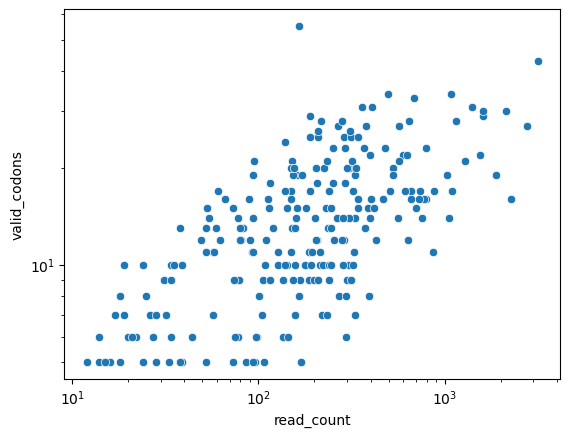

In [6]:
sns.scatterplot(data=rs_rt_ribo, x='read_count', y='valid_codons')
plt.xscale('log')
plt.yscale('log')

In [8]:
rs_rt_ribo.sort_values('read_count')

,ORF_ID,Ribo-Seq_ORF,ORF_type,status,phase_score,read_count,length,valid_codons,valid_codons_ratio,read_density,transcript_id,transcript_type,gene_id,gene_name,gene_type,chrom,strand,start_codon,profile
450,ENST00000522629.5_66775295_66793665_75,c8riboseqorf54,super_uORF,translating,0.721110,12,75,5,0.200000,0.480000,ENST00000522629.5,protein_coding,ENSG00000104205.16,SGK3,protein_coding,chr8,+,ATG,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
134,ENST00000263655.4_68319536_68319661_126,c2norep74,super_uORF,translating,1.000000,14,126,6,0.142857,0.333333,ENST00000263655.4,protein_coding,ENSG00000119865.9,CNRIP1,protein_coding,chr2,-,ATG,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, ..."
360,ENST00000469230.5_26383211_26383270_60,c6riboseqorf20,super_uORF,translating,0.978329,14,60,5,0.250000,0.700000,ENST00000469230.5,protein_coding,ENSG00000124508.17,BTN2A2,protein_coding,chr6,+,ATG,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, ..."
270,ENST00000263967.4_179148566_179198789_78,c3riboseqorf168,super_uORF,translating,0.991147,15,78,5,0.192308,0.576923,ENST00000263967.4,protein_coding,ENSG00000121879.6,PIK3CA,protein_coding,chr3,+,ATG,"[0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
34,ENST00000454000.6_21440311_21444993_84,c1norep50,super_uORF,translating,0.677174,15,84,5,0.178571,0.535714,ENST00000454000.6,protein_coding,ENSG00000142794.19,NBPF3,protein_coding,chr1,+,ATG,"[2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,ENST00000256015.5_92145760_92145828_69,c12riboseqorf108,super_uORF,translating,0.696561,1886,69,19,0.826087,82.000000,ENST00000256015.5,protein_coding,ENSG00000133639.6,BTG1,protein_coding,chr12,-,ATG,"[1089, 19, 13, 12, 0, 0, 15, 1, 17, 52, 3, 48,..."
762,ENST00000674173.1_22838748_22838858_111,c15riboseqorf1,super_uORF,translating,0.672680,2124,111,30,0.810811,57.405405,ENST00000674173.1,protein_coding,ENSG00000140157.16,NIPA2,protein_coding,chr15,+,ATG,"[356, 20, 2, 149, 17, 3, 70, 0, 1, 3, 0, 0, 70..."
341,ENST00000506983.5_176361651_176361710_60,c5riboseqorf127,super_uORF,translating,0.847128,2274,60,16,0.800000,113.700000,ENST00000506983.5,protein_coding,ENSG00000122203.15,KIAA1191,protein_coding,chr5,-,ATG,"[1195, 6, 87, 102, 4, 6, 60, 81, 2, 16, 0, 2, ..."
135,ENST00000337288.10_96208547_96208630_84,c2riboseqorf66,super_uORF,translating,0.731404,2784,84,27,0.964286,99.428571,ENST00000337288.10,protein_coding,ENSG00000084090.14,STARD7,protein_coding,chr2,-,ATG,"[227, 5, 10, 348, 103, 20, 883, 7, 156, 0, 0, ..."
